In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

import xgboost as xgb  #XGBM algorithm
#from xgboost import XGBRegressor

In [2]:
os.chdir("C:/Users/ADITHYA CHITTURI/Downloads/houseprice")

#Load the data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
#Number columns are picked and Id, SalePrice are removed from the list.
previous_num_columns = train_data.select_dtypes(exclude=['object']).columns.values.tolist()
previous_num_columns.remove('Id')
previous_num_columns.remove('SalePrice')
print(previous_num_columns)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


<Axes: xlabel='LotFrontage', ylabel='Density'>

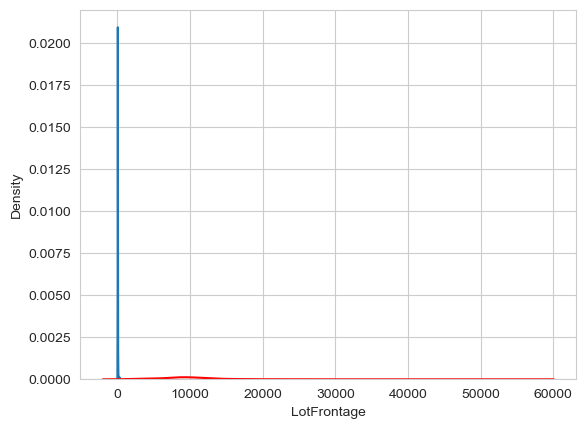

In [4]:
#Delete Outlier Data
#Check LotFrontage, LotArea, MasVnrArea.... column trend in Train and Test,.
#KDE plot: Kernel Density Estimate plot
sns.kdeplot(train_data['LotFrontage'])
sns.kdeplot(test_data['LotArea'], color="r")

<Axes: xlabel='LotArea', ylabel='Density'>

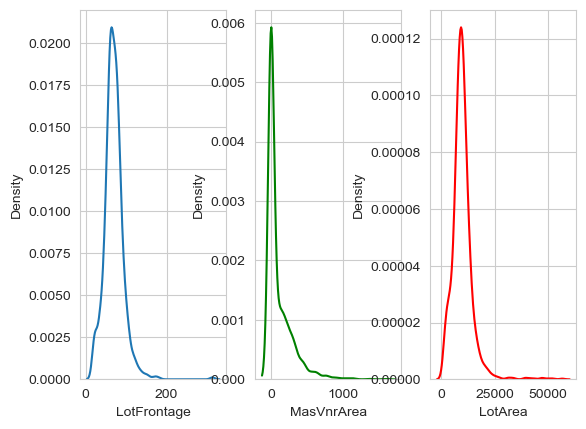

In [5]:
#sharey: Share Y Axis
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False)
sns.kdeplot(train_data['LotFrontage'], ax=ax1)
sns.kdeplot(train_data['MasVnrArea'], ax=ax2, color="g")
sns.kdeplot(test_data['LotArea'], ax=ax3,color="r")

In [6]:
#Now check the data -- how many records are there with > 1500 in train and test -- Compare the same with the above plot
print('train:', train_data['LotFrontage'][train_data['LotFrontage'] > 200].shape)
print('train:', train_data['LotArea'][train_data['LotArea'] > 60000].shape)
print('train:', train_data['MasVnrArea'][train_data['MasVnrArea'] > 1500].shape)


train: (2,)
train: (6,)
train: (1,)


In [7]:
# print('test:', test_data['LotFrontage'][test_data['LotFrontage'] > 200].shape)
# print('test:', test_data['LotArea'][test_data['LotArea'] > 60000].shape)
# print('test:', test_data['MasVnrArea'][test_data['MasVnrArea'] > 1500].shape)
# 
#==============================================================================
print(train_data.shape)
train_data.drop(train_data[train_data["LotFrontage"] > 200].index, inplace=True)
train_data.drop(train_data[train_data["LotArea"] > 60000].index, inplace=True)
train_data.drop(train_data[train_data["MasVnrArea"] > 1500].index, inplace=True)
print(train_data.shape)

(1460, 81)
(1452, 81)


In [8]:
train_length = train_data.shape[0]


In [9]:

#Both Train and Test are combined to perform EDA and FE
combined_data = pd.concat([train_data.loc[:, : 'SalePrice'], test_data])
combined_data = combined_data[test_data.columns]
print(combined_data.shape)


(2911, 80)


In [10]:
#Filling missing Values
#missing data columns are obtained -- 
has_null_columns = combined_data.columns[combined_data.isnull().any()].tolist()

In [11]:
#A function to fill the missing data with given value
def fill_missing_combined_data(column, value):
    combined_data.loc[combined_data[column].isnull(),column] = value

<Axes: xlabel='Neighborhood'>

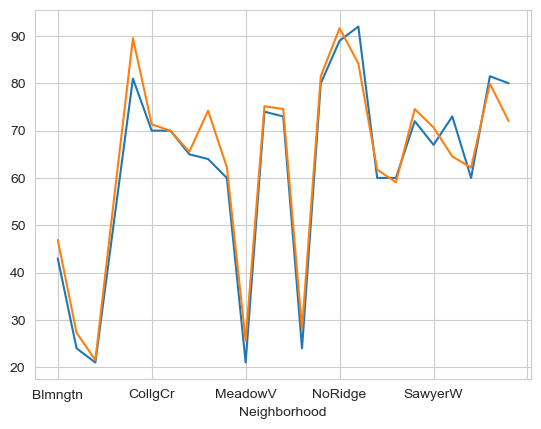

In [12]:
#Lot Frontage -- Filled with median of the Neighborhood, grouped
combined_data['LotFrontage'].groupby(combined_data["Neighborhood"]).median().plot()
combined_data['LotFrontage'].groupby(combined_data["Neighborhood"]).mean().plot()


In [13]:
#You can also group by multiple columns
lf_neighbor_map = combined_data['LotFrontage'].groupby([combined_data["Neighborhood"], combined_data["HouseStyle"]]).median()
print(lf_neighbor_map)

Neighborhood  HouseStyle
Blmngtn       1Story        43.0
Blueste       1Story        35.0
              2Story        24.0
BrDale        2Story        21.0
BrkSide       1.5Fin        52.0
                            ... 
Timber        2Story        83.0
              SLvl          73.0
Veenker       1Story        80.0
              2Story         NaN
              SLvl          80.0
Name: LotFrontage, Length: 105, dtype: float64


In [14]:

#Get the records with missing values and fill median of Neighborhood group.
rows = combined_data['LotFrontage'].isnull()
combined_data['LotFrontage'][rows] = combined_data['Neighborhood'][rows].map(lambda neighbor : lf_neighbor_map[neighbor])


C:\Users\ADITHYA CHITTURI\AppData\Local\Temp\ipykernel_11904\985369125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['LotFrontage'][rows] = combined_data['Neighborhood'][rows].map(lambda neighbor : lf_neighbor_map[neighbor])


In [15]:
#Check the LotFrontage missing data records -- which is now zero
combined_data[combined_data['LotFrontage'].isnull()]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [16]:
#Alley -- All the missing values are filled with NA, which means No Alley
combined_data.shape
train_data[train_data['Alley'].isnull()].shape
combined_data[combined_data['Alley'].isnull()].shape
fill_missing_combined_data('Alley', 'NA')

In [17]:

#FireplaceQu - For Fireplaces 0, FireplaceQu is set to NA, indicating No Fireplace, which is the case of missing 1420 records of data
combined_data[combined_data['FireplaceQu'].isnull()].shape
fill_missing_combined_data('FireplaceQu', 'NA')


In [18]:

combined_data[combined_data['PoolQC'].isnull()].shape
fill_missing_combined_data('PoolQC', 'NA')

combined_data[combined_data['MiscFeature'].isnull()].shape
fill_missing_combined_data('MiscFeature', 'NA')

combined_data[combined_data['Fence'].isnull()].shape
fill_missing_combined_data('Fence', 'NA')

In [19]:
#Fill isnull(N/A) records with 'None' in this case
combined_data[combined_data['MasVnrArea'].isnull()].shape
combined_data['MasVnrType'].fillna('None', inplace=True)
#Fill isnull(N/A) records with 0 in this case
combined_data['MasVnrArea'].fillna(0, inplace=True)

In [20]:
#Basement columns -- BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']


In [21]:
#The data for the missing string type is filled with NA, which means No Basement
for column in basement_cols:
    if 'FinSF' not in column:
        #print(column)
        fill_missing_combined_data(column, 'NA')
    else:
        print(column)
        fill_missing_combined_data(column, 0)

BsmtFinSF1
BsmtFinSF2


In [22]:
#Few other Basement related continous columns are filled with 0 -- which means no basement
fill_missing_combined_data('BsmtUnfSF', 0)
fill_missing_combined_data('TotalBsmtSF', 0)
fill_missing_combined_data('BsmtFullBath', 0)
fill_missing_combined_data('BsmtHalfBath', 0)


In [23]:
#Garage Columns
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']


In [24]:

#The data for the missing string type is filled with NA, which means No Garage
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        fill_missing_combined_data(column, 'NA')
    else:
        fill_missing_combined_data(column, 0)

In [25]:
#Check if there is any missing data
has_null_columns = combined_data.columns[combined_data.isnull().any()].tolist()
print(has_null_columns)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']


In [26]:
#Fill with Mode
#Electrical - Missing a piece of data, filled with the highest number of occurrences.
sns.countplot(combined_data['Utilities'], data=combined_data) #To get the most frequent value which is Mode
fill_missing_combined_data('MSZoning', 'RL')
fill_missing_combined_data('Utilities', 'AllPub')
fill_missing_combined_data('Exterior1st', 'VinylSd')
fill_missing_combined_data('Exterior2nd', 'VinylSd')
fill_missing_combined_data('Electrical', 'SBrkr')
fill_missing_combined_data('KitchenQual', 'TA')
fill_missing_combined_data('Functional', 'Typ')
fill_missing_combined_data('SaleType', 'WD')

TypeError: countplot() got multiple values for argument 'data'

In [ ]:
#Check if there is any missing data -- It should be empty now
has_null_columns = combined_data.columns[combined_data.isnull().any()].tolist( )
print(has_null_columns)
##End of EDA

ValueError: Expected 2D array, got scalar array instead:
array=1955.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

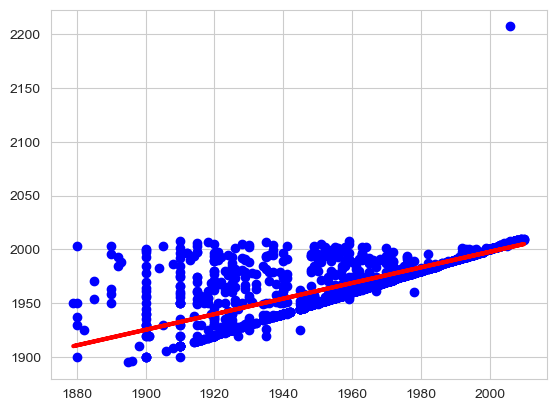

In [27]:

#Now Feature Engineering
built_year_data = combined_data[['YearBuilt', 'GarageYrBlt']][combined_data['GarageYrBlt'] != 'NA']
built_year_data['GarageYrBlt'] = built_year_data['GarageYrBlt'].map(lambda g : int(g))
built_year_data['GarageYrBlt'].corr(built_year_data['YearBuilt'])

#You can see that there is a high correlation between YearBuilt and GarageYrBlt.
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
garage_year = built_year_data.loc[:,'GarageYrBlt'].values
built_year = built_year_data.loc[:,'YearBuilt'].values

length = garage_year.shape[0]
garage_year = garage_year.reshape(length, 1)
built_year = built_year.reshape(length, 1)

# Train the model using the training sets
regr.fit(built_year, garage_year)
plt.scatter(built_year, garage_year, color='blue')
#TODO: Predict only NA values
plt.plot(built_year, regr.predict(built_year), color='red',linewidth=3)

combined_data['GarageYrBlt'] = combined_data.apply(lambda row : int(regr.predict(row['YearBuilt']))if (row['GarageYrBlt'] == 'NA') else int(row['GarageYrBlt']),axis=1)
combined_data['GarageYrBlt'].head(41)
#combined_data = sqlContext.createDataFrame(combined_data)
#combined_data.registerTempTable('tmp')
#data = sqlContext.sql('select GarageYrBlt from tmp where Id == 40').show()
# =============================================================================
#New Columns
#YearBuilt and YearRemodAdd determines whether the renovation
#How many years has remoded from built
combined_data['RemodYears'] = combined_data['YearRemodAdd'] - combined_data['YearBuilt']
#Did a remodeling happened from built?
combined_data["HasRemodeled"] = (combined_data["YearRemodAdd"] != combined_data["YearBuilt"])
#Did a remodeling happen in the year the house was sold?
combined_data["HasRecentRemodel"] = (combined_data["YearRemodAdd"] == combined_data["YrSold"])
#How many years garage is built?
combined_data['GarageBltYears'] = combined_data['GarageYrBlt'] - combined_data['YearBuilt']
combined_data.info()
#How many years has build now?
combined_data['Now_YearBuilt'] = pd.Timestamp.now().year - combined_data['YearBuilt']
combined_data['Now_YearRemodAdd'] = pd.Timestamp.now().year - combined_data['YearRemodAdd']
#combined_data['Now_GarageYrBlt'] = pd.Timestamp.now().year - combined_data['GarageYrBlt']

#==============================================================================
# #Convert MSSubClass to new categorical column with new value
# mssubclass_dict = {20: 'SC20',30: 'SC30',40: 'SC40',45: 'SC45',50: 'SC50',60: 'SC60',70: 'SC70',75: 'SC75',80: 'SC80',85: 'SC85',90: 'SC90',120: 'SC120',150: 'SC150',160: 'SC160',180: 'SC180',190: 'SC190'}
# combined_data['MSSubClass'] = combined_data['MSSubClass'].replace(mssubclass_dict)
# 
#==============================================================================

# =============================================================================
#Encoding attributes that are large and small
good_level_map = {'Street': {'Grvl': 0, 'Pave': 1},
     'Alley': {'NA':0, 'Grvl': 1, 'Pave': 2},
     'Utilities': {'AllPub':3, 'NoSeWa': 1, 'NoSewr': 2, 'ELO': 0},
     'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,'NA': 0},
     'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtFinType1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'BsmtFinType2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'CentralAir': {'N':0, 'Y':1},
     'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
     'Functional': {'Typ':6,'Min1':5,'Min2':4,'Mod':3,'Maj1':2,'Maj2':1,'Sev':0,'Sal': 0},
     'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0},
     'Fence': {'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1, 'NA': 0}
    }
print(combined_data.shape)
print(good_level_map.keys())
keys = list(good_level_map.keys())

#Replace with the values from above dictionary
good_level_data=combined_data[keys].replace(good_level_map)
good_level_data.head(2)
good_level_data.columns = good_level_data.columns.map(lambda m : m + '_New')
combined_data[good_level_data.columns] = good_level_data[good_level_data.columns]
print(combined_data.shape)
# =============================================================================

#Create new features
num_columns = combined_data.select_dtypes(include=['number']).columns.values
str_columns = combined_data.select_dtypes(exclude=['number']).columns.values

str_columns

#1.Create some boolean features
sns.countplot(combined_data["LotShape"])
sns.countplot(combined_data["LandContour"])

# IR2 and IR3 don't appear that often, so just make a distinction between regular and irregular in case of Lot Shape
combined_data["IsRegularLotShape"] = (combined_data["LotShape"] == "Reg") * 1
# Bnk, Low, HLS don't appear that often, so just make a distinction between leveled or not
combined_data["IsLandContourLvl"] = (combined_data["LandContour"] == "Lvl") * 1

sns.countplot(combined_data["GarageType"])
#Garage type may not make scence to make it Boolean columns             
             
sns.countplot(combined_data["MiscFeature"])
# The only interesting "misc. feature" is the presence of a shed.
combined_data["HasShed"] = (combined_data["MiscFeature"] == "Shed") * 1

#Was this house sold in the year it was built?
combined_data["IsSoldInBuiltYear"] = (combined_data["YearBuilt"] == combined_data["YrSold"]) * 1

#2.Simplifications of existing features -- Convert them to good, average and bad
combined_data["SimplOverallQual"] = combined_data.OverallQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                            })
combined_data["SimplOverallCond"] = combined_data.OverallCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                             })

# 3.Combinations of existing features
# Overall quality of the house
combined_data["OverallGrade"] = combined_data["OverallQual"] * combined_data["OverallCond"]
# Total number of bathrooms
combined_data["TotalBath"] = combined_data["BsmtFullBath"] + (0.5 * combined_data["BsmtHalfBath"]) + combined_data["FullBath"] + (0.5 * combined_data["HalfBath"])
# Total yard area in square feet
combined_data["TotalPorchSF"] = combined_data["OpenPorchSF"] + combined_data["EnclosedPorch"] + combined_data["3SsnPorch"] + combined_data["ScreenPorch"]
# Total SF for house (living, basement, porch, pool)
combined_data["AllSF"] = combined_data["GrLivArea"] + combined_data["TotalBsmtSF"] + combined_data["TotalPorchSF"] + combined_data["WoodDeckSF"] + combined_data["PoolArea"]

#Split Train and Test from Combined Data
train_data_new = combined_data.iloc[:train_length,:]
test_data_new = combined_data.iloc[train_length:, 1:]

#Setting X-Train and Y-Train
train_Y = train_data['SalePrice']
train_X = train_data_new.select_dtypes(exclude=['object']).drop(['Id'], axis=1)

xgb_regressor = XGBRegressor(seed=10)
xgb_regressor.fit(train_X, train_Y)